In [1]:
from __future__ import print_function
%matplotlib inline
from machinedesign.viz import grid_of_images, grid_of_images_default
from itertools import chain
import numpy as np
import sys
from skimage.io import imsave
from IPython.display import Image
from skimage.io import imsave

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from loader import  ImageFolder
from PIL import Image, ImageOps

class Scale(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        return img.resize((self.size, self.size), self.interpolation)

transform = transforms.Compose([
  transforms.Scale(128),
  transforms.CenterCrop(128),
  #transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = ImageFolder(root='/home/mcherti/work/data/insects/img_classes', transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=32,
    shuffle=True, 
    num_workers=1)

sys.path.append('pytorch_pretrained')
clf = torch.load('pytorch_pretrained/clf-4cf42cbb-3c69-4d3f-86e1-c050330a7c7c.th').cuda()
clf_mean = np.array([0.485, 0.456, 0.406], dtype='float32')
clf_mean = clf_mean[np.newaxis, :, np.newaxis, np.newaxis]
clf_mean = torch.from_numpy(clf_mean)
clf_mean = Variable(clf_mean).cuda()
clf_std = np.array([0.229, 0.224, 0.225], dtype='float32')
clf_std = clf_std[np.newaxis, :, np.newaxis, np.newaxis]
clf_std = torch.from_numpy(clf_std)
clf_std = Variable(clf_std).cuda()

def norm(x):
    x = (x + 1) / 2.
    x = x - clf_mean.repeat(x.size(0), 1, x.size(2), x.size(3))
    x = x / clf_std.repeat(x.size(0), 1, x.size(2), x.size(3))
    return x

clf_conv, clf_fc = clf.children()
clf_hid = nn.Sequential(clf_fc[0])
def features(x):
    x = norm(x)
    x = clf_conv(x)
    x = x.view(x.size(0), -1)
    x = clf_hid(x)
    return x


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/torch/serialization.py:277: SourceChangeWarning: source code of class 'batch_classifier.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
def store_val(x):
    global xgrad
    xgrad = x

In [6]:
xgrad = None
for i, data in enumerate(dataloader):    
    X, y = data
    X = Variable(X, requires_grad=True).cuda()
    y = Variable(y).cuda()
    Ximg = X
    X.register_hook(store_val)
    X = norm(X)
    y_pred = nn.Softmax()(clf(X))
    vals, indices = y_pred.max(1)
    L = Variable(torch.zeros(1)).cuda()
    for i in range(y_pred.size(0)):
        L += y_pred[i, indices[i].data[0]]
    L.backward()
    break

(32, 1, 128, 128)


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


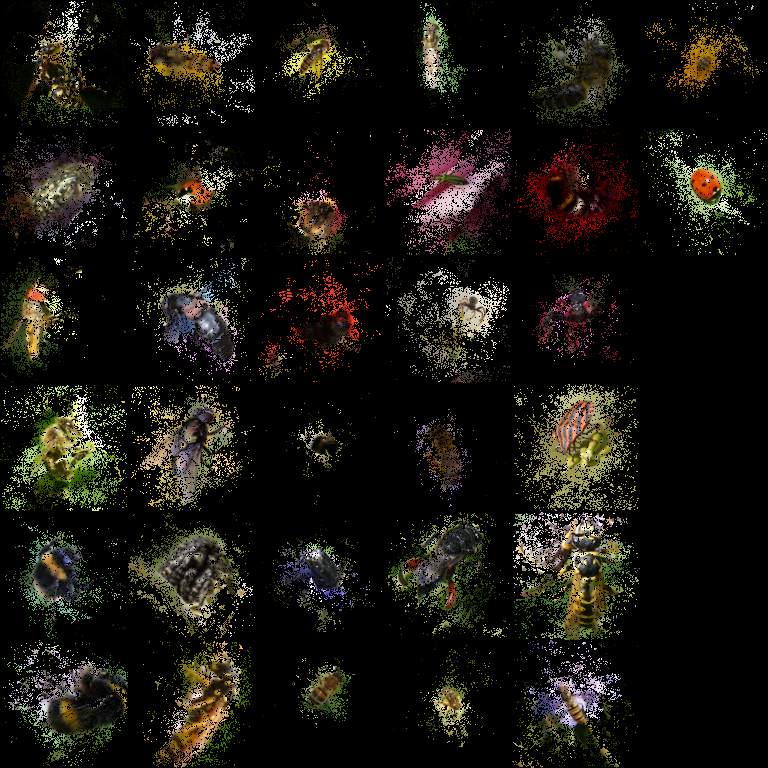

In [98]:
xi = (Ximg.data.cpu().numpy() + 1) / 2
xim = xi
xg = xgrad.data.abs().max(1)[0].cpu().numpy()
print(xg.shape)
xg -= xg.min(axis=(1,2,3), keepdims=True)
xg /= xg.max(axis=(1,2,3), keepdims=True)
xi = xi * (xg>0.05)
img = grid_of_images(xi)
imsave('out.png', img)
Image('out.png')

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


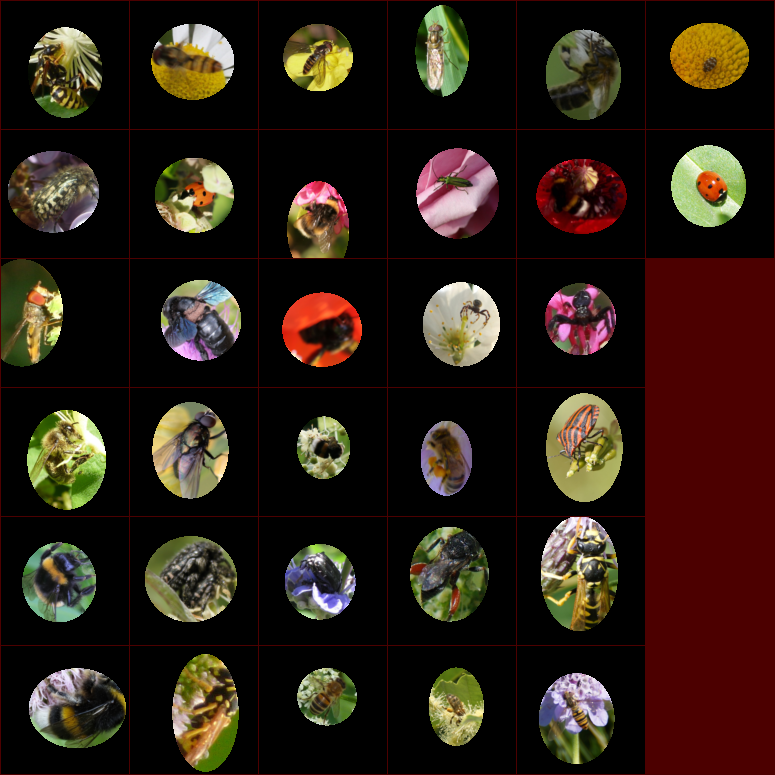

In [99]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
from skimage import morphology
from scipy import ndimage as ndi
from skimage import segmentation
from scipy.ndimage.morphology import binary_fill_holes

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, denoise_tv_bregman)
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.display import Image
imgs = []
for i in range(xim.shape[0]):
    img = xim[i].transpose((1, 2, 0))
    orig_img = img
    mask = xg[i,0]>0.05
    xx, yy = np.indices(mask.shape)
    xx = xx.flatten()
    yy = yy.flatten()
    X = np.vstack((xx, yy, xx**2, yy**2)).T
    y = mask.flatten()==1
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X, y)
    m = clf.predict_proba(X)[:, 1]>0.6
    m = m.reshape(mask.shape)
    img = img * m[:, :, np.newaxis]
    imgs.append(img)
imgs = np.array(imgs)
imgs = grid_of_images_default(imgs)
imsave('out.png', imgs)
Image('out.png')

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


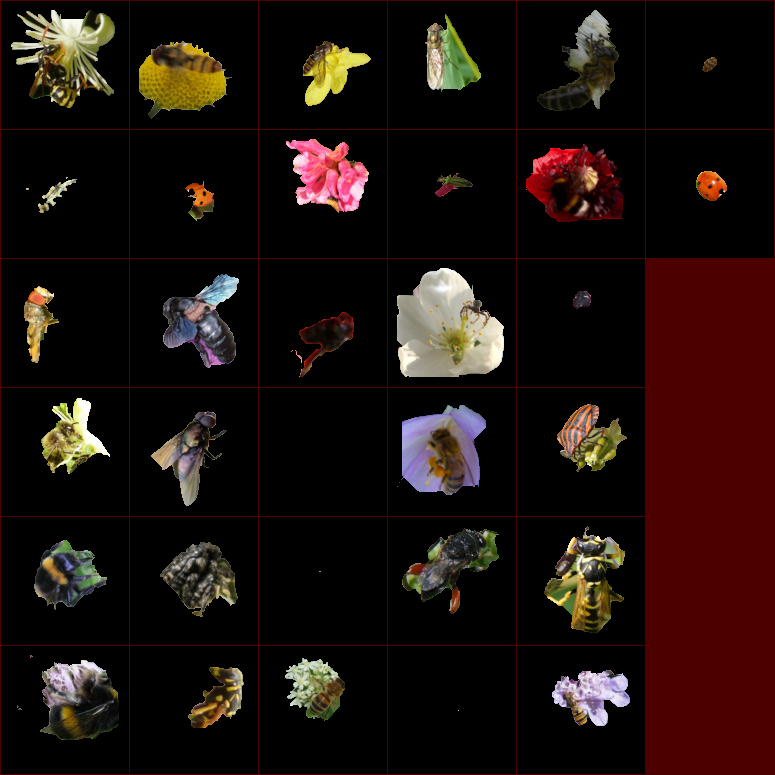

In [160]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
from skimage import morphology
from scipy import ndimage as ndi
from skimage import segmentation
from scipy.ndimage.morphology import binary_fill_holes

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, denoise_tv_bregman)
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.display import Image
from skimage.draw import ellipse
imgs = []
for i in range(xim.shape[0]):
    img = xim[i].transpose((1, 2, 0))
    orig_img = img
    mask = xg[i,0]
    xx, yy = np.indices(mask.shape)        
    C = 0
    mx = xx[mask>C].mean()
    mx_std = xx[mask>C].std()
    my = yy[mask>C].mean()
    my_std = yy[mask>C].std()

    m = np.zeros_like(mask)
    mx = int(mx)
    my = int(my)
    mx_std = int(mx_std * 1.5)
    my_std = int(my_std * 1.5)
    

    x, y, w, h = max(mx - mx_std, 0), max(my - my_std, 0), mx_std * 2, my_std * 2
    x += 1
    y += 1
    w -= 1
    h -= 1
    img_rect = x, y, w, h
    m[x:x + w, y:y+h] = 1
    img = orig_img * m[:, :, np.newaxis]
    
    # GRAB CUT
    
    mask_gc = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = img_rect
    cv2.grabCut((orig_img*255.).astype(np.uint8), mask_gc, rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask_gc==2)|(mask_gc==0), 0, 1).astype('uint8')
    img = orig_img*mask2[:,:,np.newaxis]
    imgs.append(img)
imgs = np.array(imgs)
imgs = grid_of_images_default(imgs)
imsave('out.png', imgs)
Image('out.png')

(34, 38, 48, 52)


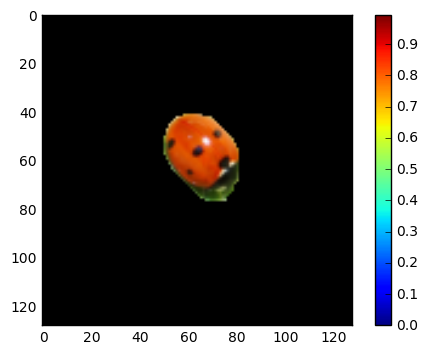

(<matplotlib.image.AxesImage at 0x7fbb20377518>,
 None)

In [70]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

mask = np.zeros(img.shape[:2],np.uint8)
#mask = m.astype(np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
#rect = (30, 30,80,80)
rect = img_rect
print(rect)
cv2.grabCut((orig_img*255.).astype(np.uint8), mask, rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = orig_img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

In [76]:
cv2.grabCut?